# Modelling using value of R0

Modelling with R0 as target variable. R0 represents the average number of people infected by one infectious individual. 

## Import libraries

In [66]:
import pandas as pd, numpy as np, time
import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
import lightgbm as lgb
from xgboost import XGBRegressor
import xgboost
from xgboost import plot_importance
from xgboost import plot_tree
from catboost import CatBoostRegressor
from sklearn.decomposition import PCA
from sklearn import preprocessing
import shap
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Lasso
%matplotlib inline

## Auxiliary Plotting Functions

##### highlight_min()
Highlights minimum values for every dataframe column

In [67]:
def highlight_min(data):
    return data.style.highlight_min(color = 'lightgreen', 
                       axis = 0)

##### aux_plot_real_vs_pred()
Creates a df with test vs predicted values of R0 and creates a bar plot

In [68]:
def aux_plot_real_vs_pred(approach, y_real, y_pred):
    plt.style.use('ggplot')
    reg_real_vs_pred = pd.DataFrame({'Actual': y_real, 'Predicted': y_pred})
    reg_real_vs_pred = reg_real_vs_pred.head(20)
    reg_real_vs_pred.plot(kind='bar', color=['darksalmon', 'cornflowerblue'],figsize=(10,5)).set_title('Predicted vs Actual Approach ' + str(approach+1))
    plt.show()

##### plot_aux()
Plots measured vs predicted values for R0s selected in trian and test together with the perfect fit line.

In [69]:
def plot_aux(approach, y_test, y_pred, y_train, y_pred_train, ax):
    ax[approach][0].scatter(y_test, y_pred, color='cornflowerblue')
    ax[approach][0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=1)
    ax[approach][0].set_title('Test Set Approach' + str(approach+1))
    ax[approach][0].set_xlabel('Measured')
    ax[approach][0].set_ylabel('Predicted')
    
    ax[approach][1].scatter(y_train, y_pred_train, color='cadetblue')
    ax[approach][1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=1)
    ax[approach][1].set_xlabel('Measured')
    ax[approach][1].set_ylabel('Predicted')
    ax[approach][1].set_title('Train Set Approach' + str(approach+1))

##### plot_aux_dist()
Function that plots distribution of R0s predicted, test vs train

In [70]:
def plot_aux_dist(approach, y_test, y_train, y_pred, y_pred_train, axes):
    
    y_test_pred = y_pred
    y_train_pred = y_pred_train

    test = y_test
    train = y_train

    res_df_test = pd.DataFrame({'pred': y_test_pred, 'test': test})
    res_df_test['dif'] = np.round(res_df_test['pred']-res_df_test['test'],2)
    res_df_test['dif_abs'] = np.round(np.abs(res_df_test['pred']-res_df_test['test']),2)
    res_df_test['dif%'] = np.round(100*(res_df_test['pred']-res_df_test['test'])/res_df_test['test'],2)

    res_df_train = pd.DataFrame({'pred': y_train_pred, 'test': train})
    res_df_train['dif'] = np.round(res_df_train['pred']-res_df_train['test'],2)
    res_df_train['dif_abs'] = np.round(np.abs(res_df_train['pred']-res_df_train['test']),2)
    res_df_train['dif%'] = np.round(100*(res_df_train['pred']-res_df_train['test'])/res_df_train['test'],2)
    
    plot = sns.kdeplot(res_df_train['pred'], ax=axes[approach][0], color='orange')
    plot = sns.kdeplot(res_df_train['test'], ax=axes[approach][0])
    plot = sns.kdeplot(res_df_test['pred'], ax=axes[approach][1], color='orange')
    plot = sns.kdeplot(res_df_test['test'], ax=axes[approach][1])
    
    axes[approach][0].set_title('Test Set Approach' + str(approach+1))
    axes[approach][1].set_title('Train Set Approach' + str(approach+1))
    
    fig.tight_layout()

#### plot_aux_reg()
Auxiliary method for regresion plot values of R0 in relation with test vs train values

In [71]:
def plot_aux_reg(approach, y_test_appch, y_pred, y_train_appch, y_pred_train, ax):
    
    sns.regplot(y_test_appch,y_pred,
           scatter_kws={"color": "steelblue"}, line_kws={"color": "lightseagreen"}, ax=axes[approach][0]) \
            .set_title('Actual vs Predicted')
    sns.regplot(y_train_appch,y_pred_train,
           scatter_kws={"color": "steelblue"}, line_kws={"color": "lightseagreen"}, ax=axes[approach][1]) \
            .set_title('Actual vs Predicted')

    axes[approach][0].set_title('Test Set Approach' + str(approach+1))
    axes[approach][1].set_title('Train Set Approach' + str(approach+1)) 

#### get_values_metric()
Returns dataframes ready to plot for coparison three models with three different approaches

In [72]:
def get_values_metric(metric):
    
    df_scores_xgb_rel=pd.DataFrame()
    df_scores_xgb_rel['Train']=df_scores_xgb_train[metric]
    df_scores_xgb_rel['Test']=df_scores_xgb[metric]
    
    df_scores_lgbm_rel=pd.DataFrame()
    df_scores_lgbm_rel['Train']=df_scores_lgbm_train[metric]
    df_scores_lgbm_rel['Test']=df_scores_lgbm[metric]
    
    df_scores_gbst_rel=pd.DataFrame()
    df_scores_gbst_rel['Train']=df_scores_gbst_train[metric]
    df_scores_gbst_rel['Test']=df_scores_gbst[metric]
    
    df_scores_knn_rel=pd.DataFrame()
    df_scores_knn_rel['Train']=df_scores_knn_train[metric]
    df_scores_knn_rel['Test']=df_scores_knn[metric]
    
    df_scores_hist_rel=pd.DataFrame()
    df_scores_hist_rel['Train']=df_scores_hist_train[metric]
    df_scores_hist_rel['Test']=df_scores_hist[metric]
    
    df_scores_NuSVR_rel=pd.DataFrame()
    df_scores_NuSVR_rel['Train']=df_scores_NuSVR_train[metric]
    df_scores_NuSVR_rel['Test']=df_scores_NuSVR[metric]
    
    return df_scores_xgb_rel,df_scores_lgbm_rel, df_scores_gbst_rel, df_scores_knn_rel, df_scores_hist_rel, df_scores_NuSVR_rel

##### get_metrics_data_frame()
Returns mae, mse, rmse and mape for passed values

In [73]:

def get_metrics_data_frame(y_appch1,y_pred_1,y_appch2,y_pred_2, y_appch3, y_pred_3):

    mae_1 = mean_absolute_error(y_appch1, y_pred_1)
    mse_1 = mean_squared_error(y_appch1, y_pred_1)
    rmse_1 = np.sqrt(mean_squared_error(y_appch1, y_pred_1))
    r2_1 = r2_score(y_appch1, y_pred_1)
    mape_1 = np.mean(np.abs((y_appch1 - y_pred_1) / y_appch1)) * 100

    mae_2 = mean_absolute_error(y_appch2, y_pred_2)
    mse_2 = mean_squared_error(y_appch2, y_pred_2)
    rmse_2 = np.sqrt(mean_squared_error(y_appch2, y_pred_2))
    r2_2 = r2_score(y_appch2, y_pred_2)
    mape_2 = np.mean(np.abs((y_appch2 - y_pred_2) / y_appch2)) * 100

    mae_3 = mean_absolute_error(y_appch3, y_pred_3)
    mse_3 = mean_squared_error(y_appch3, y_pred_3)
    rmse_3 = np.sqrt(mean_squared_error(y_appch3, y_pred_3))
    r2_3 = r2_score(y_appch3, y_pred_3)
    mape_3 = np.mean(np.abs((y_appch3 - y_pred_3) / y_appch3)) * 100

    scores = { 'mae' : {'Approach 1': mae_1, 'Approach 2': mae_2, 'Approach 3': mae_3},
               'mse' : {'Approach 1': mse_1, 'Approach 2': mse_2, 'Approach 3': mse_3},
               'rmse' : {'Approach 1': rmse_1, 'Approach 2': rmse_2, 'Approach 3': rmse_3}, 
               'mape' : {'Approach 1':mape_1, 'Approach 2':mape_2, 'Approach 3':mape_3} }
    
    df_scores=pd.DataFrame(scores)
    
    return df_scores

## Read file and prepare data 

In [74]:
df=pd.read_csv('/Users/lucas_botella/Downloads/df_covid_processed_FINAL_new_r0_chile.csv')
del df['Unnamed: 0']
df=df[['Code', 'Date', 'contact_tracing', 'retail_and_recreation',
       'grocery_and_pharmacy', 'residential', 'transit_stations', 'parks',
       'workplaces', 'debt_relief', 'income_support', 'testing_policy',
       'international_travel_controls', 'restrictions_internal_movements',
       'close_public_transport', 'public_information_campaigns',
       'facial_coverings', 'stay_home_requirements', 'restriction_gatherings',
       'cancel_public_events', 'workplace_closures', 'school_closures',
       'Holiday', 'temp', 'prcp', 'number_of_arrivals', 'urban_population',
      'total_vaccinations_per_100', '%youth_unemployment_total','excess_mortality',
      'accumulated', 'reproduction_rate']]
df = df.rename(columns={'excess_mortality': 'infected_rate'})

df['temp'] = df.apply(
    lambda row: df[pd.to_datetime(df['Date']).dt.month==pd.to_datetime(row['Date']).month]['temp'].iloc[0] if np.isnan(row['temp']) else row['temp'],
    axis=1
)
df=df[[c for c in df if c not in ['reproduction_rate']] 
       + ['reproduction_rate']]
df

,Code,Date,contact_tracing,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces,debt_relief,...,Holiday,temp,prcp,number_of_arrivals,urban_population,total_vaccinations_per_100,%youth_unemployment_total,infected_rate,accumulated,reproduction_rate
0,AUS,2020-03-29,2.0,0.714429,8.979571,-0.387571,5.448857,-2.857143,8.326571,0.000000,...,0.0,21.346512,0.142010,8263000.0,85.904,NaN,11.84,12.13,0.004356,2.170000
1,AUS,2020-04-05,2.0,-0.898000,15.163286,0.448857,-1.061286,-4.959143,6.959000,0.000000,...,0.0,21.176835,0.054789,8263000.0,85.904,NaN,11.84,11.31,0.004999,2.330000
2,AUS,2020-04-12,2.0,-10.591857,22.020286,5.102143,-21.836714,-14.836714,-0.918286,0.285714,...,0.0,20.702945,0.051898,8263000.0,85.904,NaN,11.84,6.36,0.005297,2.280000
3,AUS,2020-04-19,2.0,-32.163429,-0.020429,13.428429,-48.775571,-28.183714,-22.816286,2.000000,...,0.0,21.093375,0.073336,8263000.0,85.904,NaN,11.84,2.95,0.005879,1.457143
4,AUS,2020-04-26,2.0,-40.918429,-12.347143,17.612143,-60.204143,-39.326571,-35.265286,2.000000,...,0.0,18.880697,0.118556,8263000.0,85.904,NaN,11.84,5.75,0.006200,0.765714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3581,USA,2021-04-11,1.0,-8.816429,-4.244714,7.040714,-27.183571,4.265286,-25.775714,1.000000,...,0.0,7.624732,0.073711,75608000.0,82.058,36.955714,8.30,NaN,0.234450,1.021429
3582,USA,2021-04-18,1.0,-8.469429,-4.000143,6.632286,-26.163143,12.040857,-24.877429,1.000000,...,0.0,10.027194,0.090106,75608000.0,82.058,42.600000,8.30,NaN,0.234450,1.074286
3583,USA,2021-04-25,1.0,-8.020429,-0.142857,6.449143,-25.469286,17.755000,-27.979714,1.000000,...,0.0,21.176835,NaN,75608000.0,82.058,48.920000,8.30,NaN,0.234450,1.047143
3584,USA,2021-05-02,1.0,-7.979571,-1.816286,5.816143,-24.571429,24.347000,-26.428571,1.000000,...,0.0,19.355421,NaN,75608000.0,82.058,55.571429,8.30,NaN,0.234450,1.042857


Text(0.5, 1.0, 'reproduction_rate')

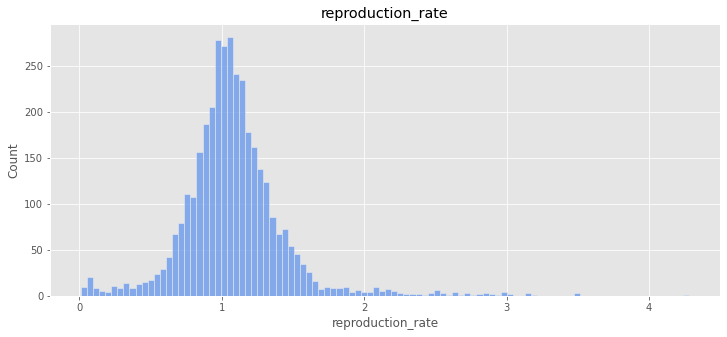

In [75]:
#Removing -inf and infinite
df=df[~df.isin([np.inf, -np.inf]).any(1)]
f, axes = plt.subplots(figsize=(12,5))
sns.histplot(x='reproduction_rate', data=df, kde=False, bins=100, ax=axes, color='cornflowerblue');
axes.set_title('reproduction_rate')

## Feature Engineering

### Approach 1: Raw data no grouping of variables or PCA Analysis
Train models with raw data, no previous transformation or grouping done

In [76]:
df_appch1=df.copy()
df_appch1_clean=df.copy()

In [77]:
#df_appch1_clean['temp'] = df_appch1_clean['temp'].fillna(df_appch1_clean['temp'].mean())
df_appch1_clean['prcp'] = df_appch1_clean['prcp'].fillna(df_appch1_clean['prcp'].mean())
df_appch1_clean['parks'] = df_appch1_clean['parks'].fillna(df_appch1_clean['prcp'].mean())
df_appch1_clean['number_of_arrivals'] = df_appch1_clean['prcp'].fillna(df_appch1_clean['prcp'].mean())
df_appch1_clean['urban_population'] = df_appch1_clean['prcp'].fillna(df_appch1_clean['prcp'].mean())
df_appch1_clean['total_vaccinations_per_100'] = df_appch1_clean['total_vaccinations_per_100'].fillna(0)
df_appch1_clean['%youth_unemployment_total']= df_appch1_clean['%youth_unemployment_total'].fillna(df_appch1_clean['%youth_unemployment_total'].mean())
df_appch1_clean = df_appch1_clean[df_appch1_clean['infected_rate'].notna()]
df_appch1_clean['accumulated']= df_appch1_clean['accumulated'].fillna(df_appch1_clean['accumulated'].mean())

### Approach 2: Grouping variables, decreasing dimensionality and correlation
Since variables seem to have high multicollinearity will group variables with similar corellation

In [78]:
df_appch2=df.copy()

In [79]:
#We define bad mobility as the weighted average of mobility trends that have a positive impact on covid spread
df_appch2['bad_mobility']=(df_appch2['retail_and_recreation']*0.4+df_appch2['transit_stations']*0.2
                           +df_appch2['grocery_and_pharmacy']*0.2+df_appch2['workplaces']*0.2)

#We define good mobility as the weighted average of mobility trends that have a negative impact on covid spread
df_appch2['good_mobility']=(df_appch2['residential']*0.6+df_appch2['parks']*0.4)

df_appch2['awareness_measures'] = df_appch2['public_information_campaigns']*0.2+df_appch2['facial_coverings']*0.8

df_appch2['government_economic_measures']=df_appch2['debt_relief']*0.5+df_appch2['income_support']*0.5
df_appch2['health_measures']=df_appch2['contact_tracing']*0.5+df_appch2['testing_policy']*0.5
df_appch2['mobility_measures']=df_appch2['stay_home_requirements'] + df_appch2['restriction_gatherings']\
                               +df_appch2['cancel_public_events'] + df_appch2['restrictions_internal_movements']\
                               +df_appch2['international_travel_controls'] + df_appch2['close_public_transport']\
                               +df_appch2['workplace_closures']+df_appch2['school_closures']

df_appch2=df_appch2[['Code', 'Date','bad_mobility', 'good_mobility', 
                    'government_economic_measures', 'health_measures',
                     'mobility_measures', 'Holiday', 'temp', 'prcp', 
                     'number_of_arrivals', 'urban_population',
                       'total_vaccinations_per_100', '%youth_unemployment_total',
                       'infected_rate', 'accumulated', 'reproduction_rate']]

In [80]:
df_appch2.head()

,Code,Date,bad_mobility,good_mobility,government_economic_measures,health_measures,mobility_measures,Holiday,temp,prcp,number_of_arrivals,urban_population,total_vaccinations_per_100,%youth_unemployment_total,infected_rate,accumulated,reproduction_rate
0,AUS,2020-03-29,4.836771,-1.375400,0.000000,1.5,3.000000,0.0,21.346512,0.142010,8263000.0,85.904,NaN,11.84,12.13,0.004356,2.170000
1,AUS,2020-04-05,3.853000,-1.714343,0.500000,1.5,4.428571,0.0,21.176835,0.054789,8263000.0,85.904,NaN,11.84,11.31,0.004999,2.330000
2,AUS,2020-04-12,-4.383686,-2.873400,0.642857,1.5,12.142857,0.0,20.702945,0.051898,8263000.0,85.904,NaN,11.84,6.36,0.005297,2.280000
3,AUS,2020-04-19,-27.187829,-3.216429,1.500000,1.5,17.571429,0.0,21.093375,0.073336,8263000.0,85.904,NaN,11.84,2.95,0.005879,1.457143
4,AUS,2020-04-26,-37.930686,-5.163343,1.500000,1.5,19.000000,0.0,18.880697,0.118556,8263000.0,85.904,NaN,11.84,5.75,0.006200,0.765714


In [131]:
df_appch2.to_csv('data_streamlit_app.csv')

<AxesSubplot:>

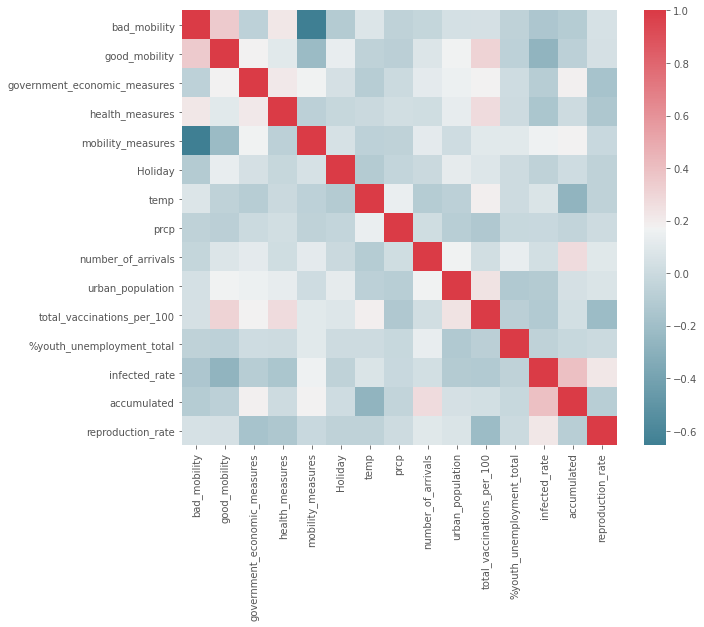

In [81]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df_appch2.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [82]:
df_appch2_clean=df_appch2.copy()
df_appch2_clean = df_appch2_clean[df_appch2_clean['bad_mobility'].notna()]
df_appch2_clean = df_appch2_clean[df_appch2_clean['good_mobility'].notna()]
#df_appch2_clean['temp'] = df_appch2_clean['temp'].fillna(df_appch2_clean['temp'].mean())
df_appch2_clean['prcp'] = df_appch2_clean['prcp'].fillna(df_appch2_clean['prcp'].mean())
df_appch2_clean['number_of_arrivals'] = df_appch2_clean['prcp'].fillna(df_appch2_clean['prcp'].mean())
df_appch2_clean['urban_population'] = df_appch2_clean['prcp'].fillna(df_appch2_clean['prcp'].mean())
df_appch2_clean['total_vaccinations_per_100'] = df_appch2_clean['total_vaccinations_per_100'].fillna(0)
df_appch2_clean['%youth_unemployment_total']= df_appch2_clean['%youth_unemployment_total'].fillna(df_appch2_clean['%youth_unemployment_total'].mean())
df_appch2_clean = df_appch2_clean[df_appch2_clean['infected_rate'].notna()]
df_appch2_clean['accumulated']= df_appch2_clean['accumulated'].fillna(df_appch2_clean['accumulated'].mean())

### Approach 3: PCA
Since variables have a high correlation we will group variables taking use of Principal Component Analysis

In [83]:
df_appch3=df.copy()
df_appch3['total_vaccinations_per_100'] = df_appch3['total_vaccinations_per_100'].fillna(0)
df_appch3['accumulated'] = df_appch3['accumulated'].fillna(0)
df_appch3['urban_population'] = df_appch3['urban_population'].fillna(df_appch3['urban_population'].mean())
df_appch3['parks'] = df_appch3['parks'].fillna(df_appch3['parks'].mean())
#df_appch3['temp'] = df_appch3['temp'].fillna(df_appch3['temp'].mean())
df_appch3['prcp'] = df_appch3['prcp'].fillna(df_appch3['prcp'].mean())
df_appch3 = df_appch3[df_appch3['retail_and_recreation'].notna()]
df_appch3 = df_appch3[df_appch3['grocery_and_pharmacy'].notna()]
df_appch3['%youth_unemployment_total']= df_appch3['%youth_unemployment_total'].fillna(df_appch3['%youth_unemployment_total'].mean())
df_appch3['number_of_arrivals']=df_appch3['number_of_arrivals'].fillna(df_appch3['number_of_arrivals'].mean())
df_appch3 = df_appch3[df_appch3['infected_rate'].notna()]


In [84]:
df_appch3.columns

Index(['Code', 'Date', 'contact_tracing', 'retail_and_recreation',
       'grocery_and_pharmacy', 'residential', 'transit_stations', 'parks',
       'workplaces', 'debt_relief', 'income_support', 'testing_policy',
       'international_travel_controls', 'restrictions_internal_movements',
       'close_public_transport', 'public_information_campaigns',
       'facial_coverings', 'stay_home_requirements', 'restriction_gatherings',
       'cancel_public_events', 'workplace_closures', 'school_closures',
       'Holiday', 'temp', 'prcp', 'number_of_arrivals', 'urban_population',
       'total_vaccinations_per_100', '%youth_unemployment_total',
       'infected_rate', 'accumulated', 'reproduction_rate'],
      dtype='object')

In [85]:
features=['contact_tracing', 'retail_and_recreation',
       'grocery_and_pharmacy', 'residential', 'transit_stations', 'parks',
       'workplaces', 'debt_relief', 'income_support', 'testing_policy',
       'international_travel_controls', 'restrictions_internal_movements',
       'close_public_transport', 'public_information_campaigns',
       'facial_coverings', 'stay_home_requirements', 'restriction_gatherings',
       'cancel_public_events', 'workplace_closures', 'school_closures',
       'Holiday', 'temp', 'prcp', 'number_of_arrivals', 'urban_population',
       'total_vaccinations_per_100', '%youth_unemployment_total',
       'infected_rate', 'accumulated']

# Separating out the features
x = df_appch3.reindex(columns = features).values
# Separating out the target
y = df_appch3.reindex(columns = ['reproduction_rate']).values
# Standardizing the features
x = StandardScaler().fit_transform(x)

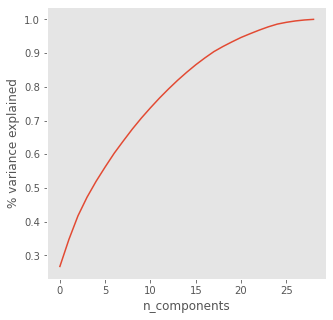

In [86]:
pca = PCA(n_components = x.shape[1])
pca_data = pca.fit_transform(x)

percent_var_explained = pca.explained_variance_/(np.sum(pca.explained_variance_))
cumm_var_explained = np.cumsum(percent_var_explained)

plt.rcParams["figure.figsize"] = (5,5)
plt.plot(cumm_var_explained)
plt.grid()
plt.xlabel("n_components")
plt.ylabel("% variance explained")
plt.show()

In [87]:
pca = PCA(n_components = 12)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents)
#Include Date and R0 for later filtering
principalDf['Date']=df_appch3['Date']
principalDf['reproduction_rate']=df_appch3['reproduction_rate']
df_appch3=principalDf

## Modelling and Evaluation

Once we have our three datasets defined and have an intuition on how our trees should look like will start with the modelling and evaluation phase

In [88]:
date=pd.Timestamp(2021, 1, 10)

#### Approach 1: Raw data no grouping of variables or PCA Analysis Split

In [89]:
X_1=df_appch1[(pd.to_datetime(df_appch1['Date']) <= date)]
X_2=df_appch1[(pd.to_datetime(df_appch1['Date']) > date)]
X_train_appch1=X_1[X_1.columns[2:-1]]
X_test_appch1=X_2[X_2.columns[2:-1]]
y_train_appch1=X_1['reproduction_rate']
y_test_appch1=X_2['reproduction_rate']

X_train_appch1, X_test_appch1, y_train_appch1, y_test_appch1 = train_test_split(df_appch1[df_appch1.columns[2:-1]], df_appch1['reproduction_rate'], test_size=0.33, random_state=42)

In [90]:
X_1_clean=df_appch1_clean[(pd.to_datetime(df_appch1_clean['Date']) <= date)]
X_2_clean=df_appch1_clean[(pd.to_datetime(df_appch1_clean['Date']) > date)]
scaler = preprocessing.StandardScaler().fit(df_appch1_clean[df_appch1_clean.columns[2:-1]])

X_train_appch1_clean = scaler.transform(X_1_clean[X_1_clean.columns[2:-1]])
X_test_appch1_clean = scaler.transform(X_2_clean[X_2_clean.columns[2:-1]])

y_train_appch1_clean=X_1_clean['reproduction_rate']
y_test_appch1_clean=X_2_clean['reproduction_rate']

####  Approach 2: Grouping variables, decreasing dimensionality and correlation Split

In [91]:
X_1=df_appch2[(pd.to_datetime(df_appch2['Date']) <= date)]
X_2=df_appch2[(pd.to_datetime(df_appch2['Date']) > date)]
X_train_appch2=X_1[X_1.columns[2:-1]]
X_test_appch2=X_2[X_2.columns[2:-1]]
y_train_appch2=X_1['reproduction_rate']
y_test_appch2=X_2['reproduction_rate']

In [92]:
X_1_clean=df_appch2_clean[(pd.to_datetime(df_appch2_clean['Date']) <= date)]
X_2_clean=df_appch2_clean[(pd.to_datetime(df_appch2_clean['Date']) > date)]
scaler = preprocessing.StandardScaler().fit(df_appch2_clean[df_appch2_clean.columns[2:-1]])

X_train_appch2_clean = scaler.transform(X_1_clean[X_1_clean.columns[2:-1]])
X_test_appch2_clean = scaler.transform(X_2_clean[X_2_clean.columns[2:-1]])

y_train_appch2_clean=X_1_clean['reproduction_rate']
y_test_appch2_clean=X_2_clean['reproduction_rate']

#### Approach 3: PCA  Split

In [93]:
X_1=df_appch3[(pd.to_datetime(df_appch3['Date']) <= date)]
X_2=df_appch3[(pd.to_datetime(df_appch3['Date']) > date)]
X_train_appch3=X_1[X_1.columns[0:-2]]
X_test_appch3=X_2[X_2.columns[0:-2]]
y_train_appch3=X_1['reproduction_rate']
y_test_appch3=X_2['reproduction_rate']

In [94]:
X_train_appch3_clean=X_train_appch3
X_test_appch3_clean=X_test_appch3
y_train_appch3_clean=y_train_appch3
y_test_appch3_clean=y_test_appch3

#### Dataframe for later evaluation of approach 2

In [95]:
df_eval_approach_2=pd.DataFrame(columns=['mae','mse','mape','rmse'])

#### Check best parameters for our trees to avoid overfitting

Initial approach on max depth and n_trees

In [96]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   19.8s finished


Best: 69.375773 using {'max_depth': 4, 'n_estimators': 100}
53.755054 (30.204246) with: {'max_depth': 4, 'n_estimators': 1}
58.835171 (63.407357) with: {'max_depth': 4, 'n_estimators': 20}
64.076456 (72.835218) with: {'max_depth': 4, 'n_estimators': 50}
69.375773 (79.873834) with: {'max_depth': 4, 'n_estimators': 100}
54.376556 (30.661442) with: {'max_depth': 6, 'n_estimators': 1}
60.221912 (66.151697) with: {'max_depth': 6, 'n_estimators': 20}
62.130787 (68.060223) with: {'max_depth': 6, 'n_estimators': 50}
63.313400 (69.156605) with: {'max_depth': 6, 'n_estimators': 100}
53.605085 (28.513172) with: {'max_depth': 8, 'n_estimators': 1}
60.311348 (66.305090) with: {'max_depth': 8, 'n_estimators': 20}
62.432519 (69.151704) with: {'max_depth': 8, 'n_estimators': 50}
62.682389 (69.496148) with: {'max_depth': 8, 'n_estimators': 100}
53.890169 (28.674765) with: {'max_depth': 10, 'n_estimators': 1}
57.357672 (58.699567) with: {'max_depth': 10, 'n_estimators': 20}
58.415723 (59.816620) with: {

Text(0, 0.5, 'MAPE')

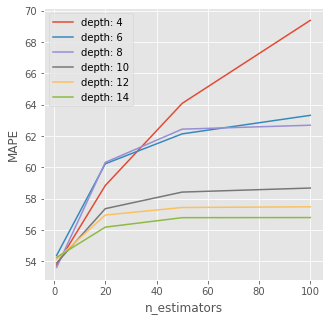

In [97]:
n_estimators = [1,20,50,100]
max_depth = [4,6,8,10, 12, 14]

model = XGBRegressor() 

param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

grid_search = GridSearchCV(model, param_grid, scoring=make_scorer(mape), n_jobs=-1, verbose=1)

grid_result = grid_search.fit(X_train_appch2, y_train_appch2)

# summarize results

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
# plot results
scores = np.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    pyplot.plot(n_estimators, scores[i], label='depth: ' + str(value))
pyplot.legend()
pyplot.xlabel('n_estimators')
pyplot.ylabel('MAPE')

As seen, best range of estimators seems to be [100, 120] with a max_depth in range [4,6], other combinations may end up with bad results or overfitting

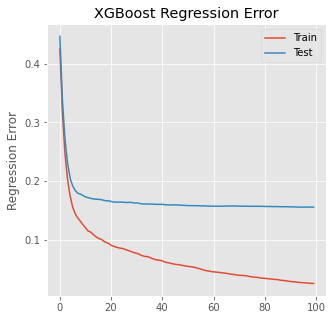

In [98]:
#Default is created with max_depth 6 and n_estimators 100 which is correct for the following analysis
model = XGBRegressor()

eval_set1 = [(X_train_appch1, y_train_appch1), (X_test_appch1, y_test_appch1)]
model.fit(X_train_appch1, y_train_appch1, eval_metric=["mae"], eval_set=eval_set1, verbose=False)


results = model.evals_result()
epochs = len(results['validation_0']['mae'])
x_axis = range(0, epochs)

fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['mae'], label='Train')
ax.plot(x_axis, results['validation_1']['mae'], label='Test')
ax.legend()
pyplot.ylabel('Regression Error')
pyplot.title('XGBoost Regression Error')
pyplot.show()

## XGBoost Regressor 

### Modelling
We will model with the restriction observed in the previous section analyzing posible tuning in the parameters for Grid Search CV, for each of the three different approaches

In [99]:
# A parameter grid for XGBoost
fit_params1={'n_estimators':[10,11,12],'max_depth' : [4,6,8]}
fit_params2={'n_estimators':[10,11,12],'max_depth' : [4,6,8]}
fit_params3={'n_estimators':[10,11,12],'max_depth' : [4,6,8]}

# Initialize XGB and GridSearch
xgb = XGBRegressor() 

grid1 = GridSearchCV(xgb, fit_params1, verbose=0, n_jobs=-1, scoring='neg_mean_absolute_error')
grid2 = GridSearchCV(xgb, fit_params2, verbose=0, n_jobs=-1,  scoring='neg_mean_absolute_error')
grid3 = GridSearchCV(xgb, fit_params3, verbose=0, n_jobs=-1,  scoring='neg_mean_absolute_error')

In [100]:
%time

eval_set1 = [(X_train_appch1, y_train_appch1), (X_test_appch1, y_test_appch1)]
eval_set2 = [(X_train_appch2, y_train_appch2), (X_test_appch2, y_test_appch2)]
eval_set3 = [(X_train_appch3, y_train_appch3), (X_test_appch3, y_test_appch3)]

grid1.fit(X_train_appch1, y_train_appch1, eval_set=eval_set1, early_stopping_rounds=5, verbose=False)
grid2.fit(X_train_appch2, y_train_appch2, eval_set=eval_set2, early_stopping_rounds=5, verbose=False)
grid3.fit(X_train_appch3, y_train_appch3, eval_set=eval_set3, early_stopping_rounds=5, verbose=False)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.2 µs


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
      

In [101]:
y_pred_1=grid1.best_estimator_.predict(X_test_appch1)
y_pred_train_1=grid1.best_estimator_.predict(X_train_appch1)
y_pred_2=grid2.best_estimator_.predict(X_test_appch2)
y_pred_train_2=grid2.best_estimator_.predict(X_train_appch2)
y_pred_3=grid3.best_estimator_.predict(X_test_appch3)
y_pred_train_3=grid3.best_estimator_.predict(X_train_appch3)

### XGB Evaluation

#### Test Set

In [102]:
df_scores_xgb=get_metrics_data_frame(y_test_appch1,y_pred_1, y_test_appch2, y_pred_2,y_test_appch3, y_pred_3)
df_eval_approach_2.loc['XGBoost Regressor'] = df_scores_xgb.loc['Approach 2']
highlight_min(df_scores_xgb)

,mae,mse,rmse,mape
Approach 1,0.164920,0.061938,0.248873,17.966071
Approach 2,0.189127,0.066991,0.258827,35.270815
Approach 3,0.153931,0.037322,0.193189,15.214011


#### Train Set

In [103]:
df_scores_xgb_train=get_metrics_data_frame(y_train_appch1,y_pred_train_1, y_train_appch2, y_pred_train_2,y_train_appch3, y_pred_train_3)
highlight_min(df_scores_xgb_train)

,mae,mse,rmse,mape
Approach 1,0.074366,0.010142,0.100709,9.052225
Approach 2,0.223054,0.096826,0.311169,31.676223
Approach 3,0.305063,0.201524,0.448914,23.666627


## Results View

#### Actual vs Predicted

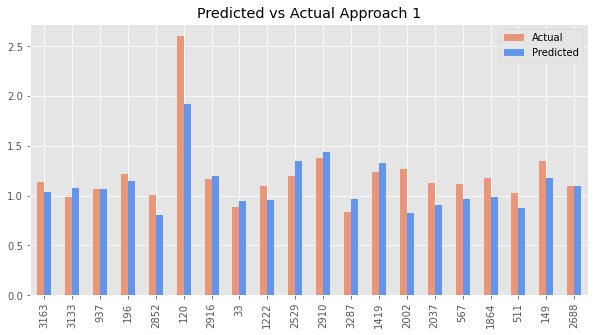

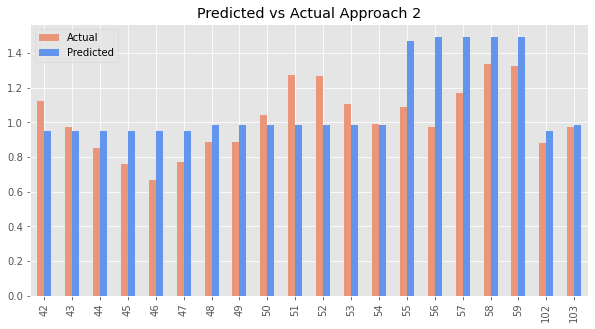

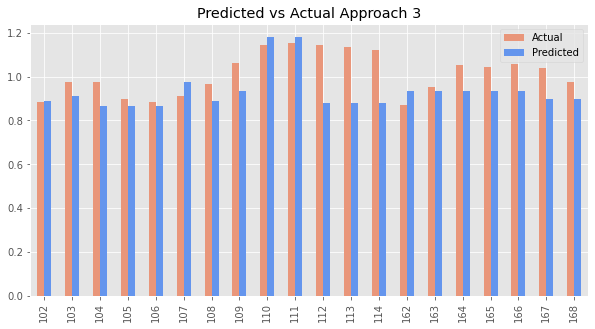

In [104]:
aux_plot_real_vs_pred(0, y_test_appch1, y_pred_1)
aux_plot_real_vs_pred(1, y_test_appch2, y_pred_2)
aux_plot_real_vs_pred(2, y_test_appch3, y_pred_3)

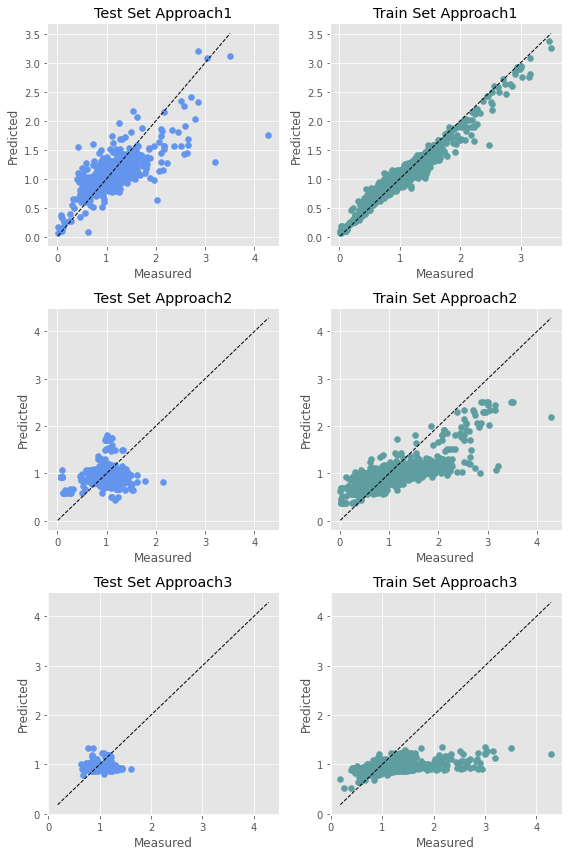

In [105]:
fig, ax = plt.subplots(3,2,figsize=(8,12))

plot_aux(0, y_test_appch1, y_pred_1, y_train_appch1, y_pred_train_1, ax)
plot_aux(1, y_test_appch2, y_pred_2, y_train_appch2, y_pred_train_2, ax)
plot_aux(2, y_test_appch3, y_pred_3, y_train_appch3, y_pred_train_3, ax)

fig.tight_layout()
plt.show()

* As seen Approach 3 using PCA seems to be the one getting the "best" results. However none of them seem to be fitting R0 correctly specially with larger values of R0.
* It is also important to note that the test set has a smaller rangeof values

### Distribution plots

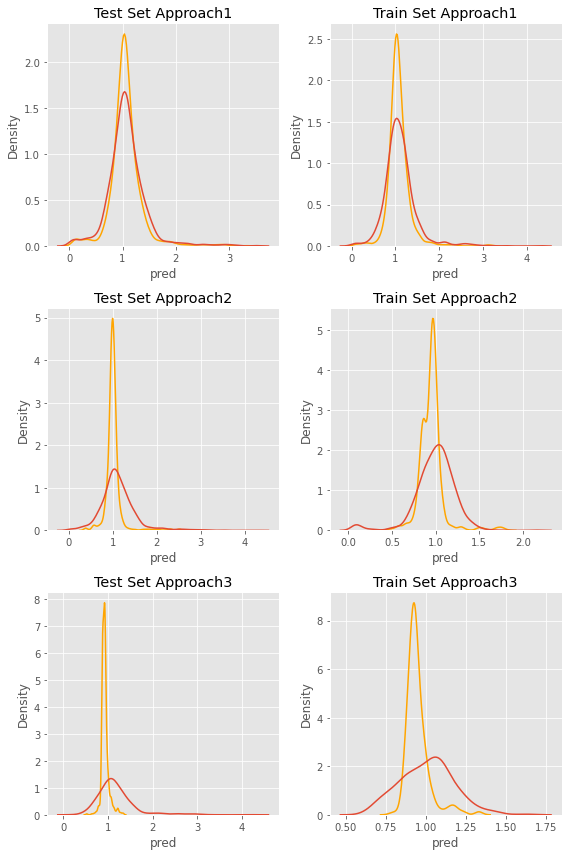

In [106]:
fig, ax = plt.subplots(3,2,figsize=(8,12))

plot_aux_dist(0, y_test_appch1, y_train_appch1, y_pred_1, y_pred_train_1, ax)
plot_aux_dist(1, y_test_appch2, y_train_appch2, y_pred_2, y_pred_train_2, ax)
plot_aux_dist(2, y_test_appch3, y_train_appch3, y_pred_3, y_pred_train_3, ax)

plt.show()

## Light GBM

### Modelling 

In [107]:
fit_params1={'n_estimators':[40,50,60],'max_depth' : [10,12,14]}
fit_params2={'n_estimators':[40,50,60],'max_depth' : [10,12,14]}
fit_params3={'n_estimators':[40,50,60],'max_depth' : [10,12,14]}


# Initialize LGB and GridSearch
lgbm = lgb.LGBMRegressor()

grid1 = GridSearchCV(lgbm, fit_params1, verbose=0)
grid2 = GridSearchCV(lgbm, fit_params2, verbose=0)
grid3 = GridSearchCV(lgbm, fit_params3, verbose=0)

In [108]:
%%time

eval_set1 = [(X_train_appch1, y_train_appch1), (X_test_appch1, y_test_appch1)]
eval_set2 = [(X_train_appch2, y_train_appch2), (X_test_appch2, y_test_appch2)]
eval_set3 = [(X_train_appch3, y_train_appch3), (X_test_appch3, y_test_appch3)]

grid1.fit(X_train_appch1, y_train_appch1, eval_set=eval_set1, verbose=False)
grid2.fit(X_train_appch2, y_train_appch2, eval_set=eval_set2, verbose=False)
grid3.fit(X_train_appch3, y_train_appch3, eval_set=eval_set3, verbose=False)

CPU times: user 1min 15s, sys: 3.41 s, total: 1min 18s
Wall time: 27.8 s


GridSearchCV(estimator=LGBMRegressor(),
             param_grid={'max_depth': [10, 12, 14],
                         'n_estimators': [40, 50, 60]})

In [109]:
y_pred_1=grid1.best_estimator_.predict(X_test_appch1)
y_pred_train_1=grid1.best_estimator_.predict(X_train_appch1)
y_pred_2=grid2.best_estimator_.predict(X_test_appch2)
y_pred_train_2=grid2.best_estimator_.predict(X_train_appch2)
y_pred_3=grid3.best_estimator_.predict(X_test_appch3)
y_pred_train_3=grid3.best_estimator_.predict(X_train_appch3)

### Evaluation

#### Test Set

In [110]:
df_scores_lgbm=get_metrics_data_frame(y_test_appch1,y_pred_1, y_test_appch2, y_pred_2,y_test_appch3, y_pred_3)
df_eval_approach_2.loc['Light GBM'] = df_scores_lgbm.loc['Approach 2']
highlight_min(df_scores_lgbm)

,mae,mse,rmse,mape
Approach 1,0.159899,0.056642,0.237996,18.802432
Approach 2,0.180543,0.060112,0.245176,35.694062
Approach 3,0.238816,0.087553,0.295893,26.328058


#### Train Set

In [111]:
df_scores_lgbm_train=get_metrics_data_frame(y_train_appch1,y_pred_train_1, y_train_appch2, y_pred_train_2,y_train_appch3, y_pred_train_3)
highlight_min(df_scores_lgbm_train)

,mae,mse,rmse,mape
Approach 1,0.101108,0.018666,0.136623,13.570744
Approach 2,0.137178,0.036527,0.191120,18.201876
Approach 3,0.161099,0.059506,0.243938,14.881828


## Results View

#### Actual vs Predicted

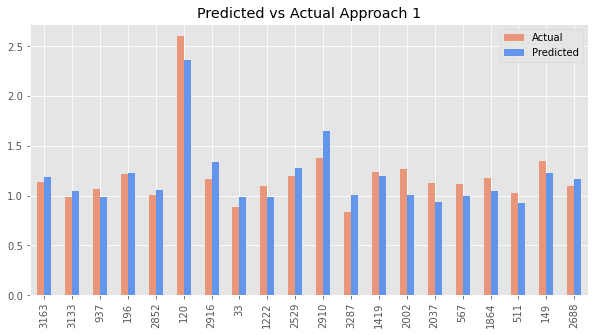

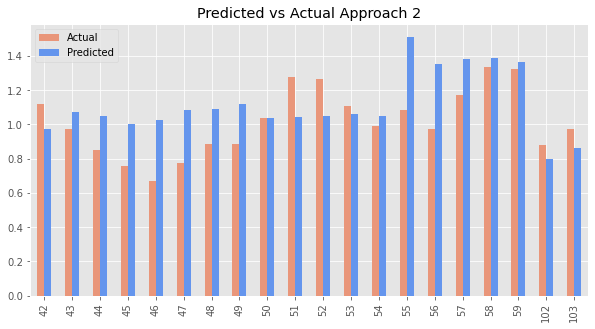

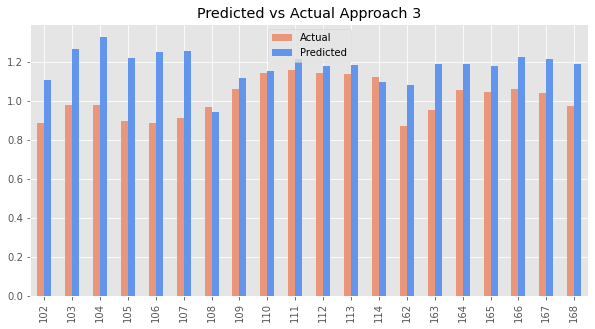

In [112]:
aux_plot_real_vs_pred(0, y_test_appch1, y_pred_1)
aux_plot_real_vs_pred(1, y_test_appch2, y_pred_2)
aux_plot_real_vs_pred(2, y_test_appch3, y_pred_3)

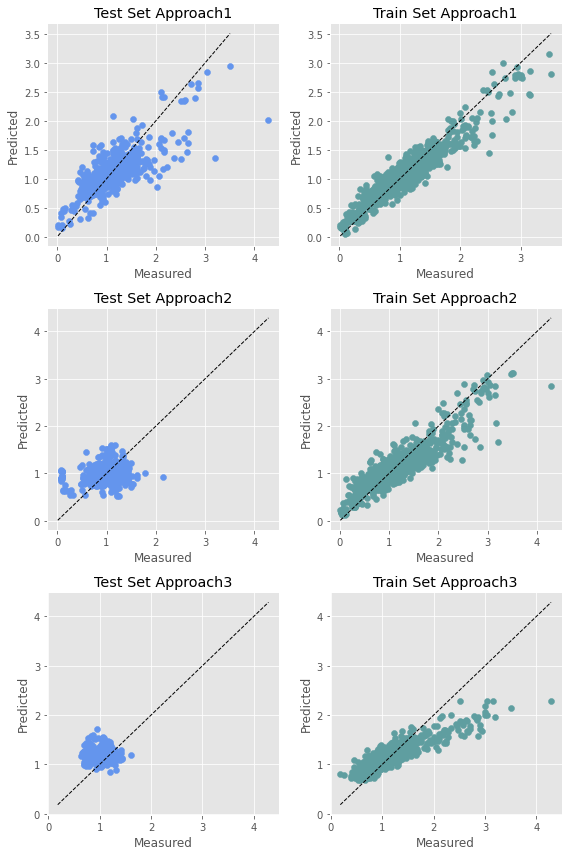

In [113]:
fig, ax = plt.subplots(3,2,figsize=(8,12))

plot_aux(0, y_test_appch1, y_pred_1, y_train_appch1, y_pred_train_1, ax)
plot_aux(1, y_test_appch2, y_pred_2, y_train_appch2, y_pred_train_2, ax)
plot_aux(2, y_test_appch3, y_pred_3, y_train_appch3, y_pred_train_3, ax)

fig.tight_layout()
plt.show()

* As seen Approach 3 using PCA seems to be the one getting the "best" results. However none of them seem to be fitting R0 correctly specially with larger values of R0.
* It is also important to note that the test set has a smaller rangeof values

### Distribution plots

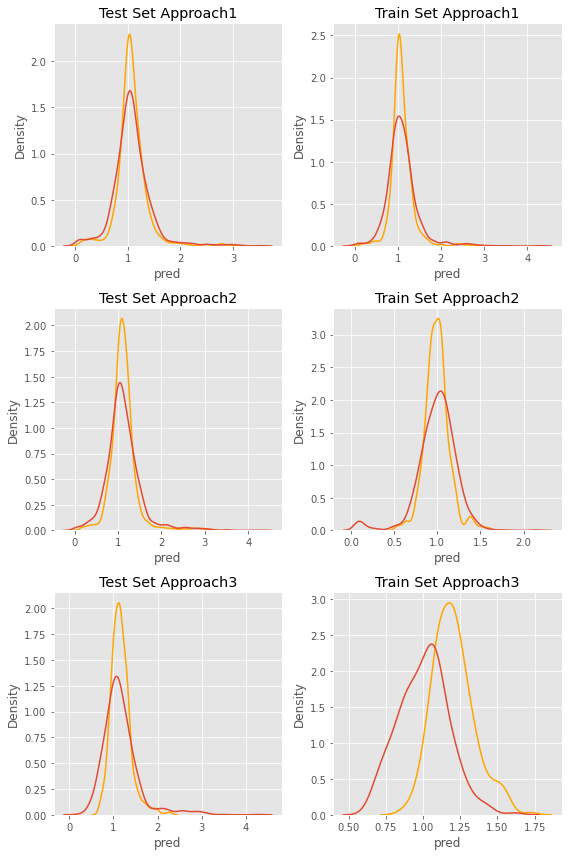

In [114]:
fig, ax = plt.subplots(3,2,figsize=(8,12))

plot_aux_dist(0, y_test_appch1, y_train_appch1, y_pred_1, y_pred_train_1, ax)
plot_aux_dist(1, y_test_appch2, y_train_appch2, y_pred_2, y_pred_train_2, ax)
plot_aux_dist(2, y_test_appch3, y_train_appch3, y_pred_3, y_pred_train_3, ax)

plt.show()

## Results View

#### Actual vs Predicted

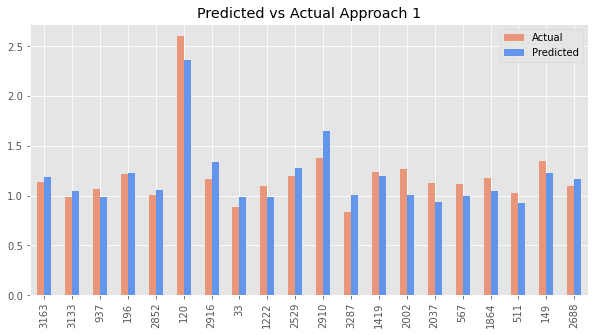

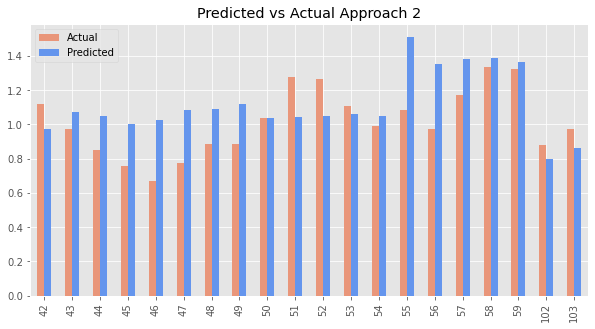

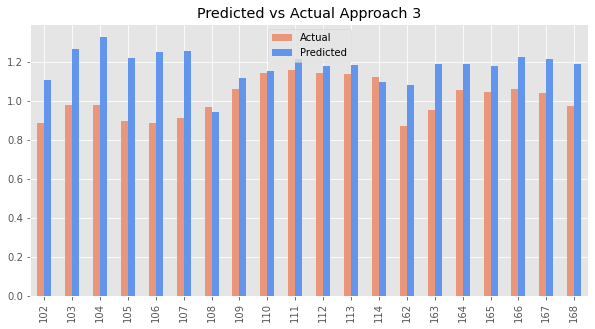

In [115]:
aux_plot_real_vs_pred(0, y_test_appch1, y_pred_1)
aux_plot_real_vs_pred(1, y_test_appch2, y_pred_2)
aux_plot_real_vs_pred(2, y_test_appch3,y_pred_3)

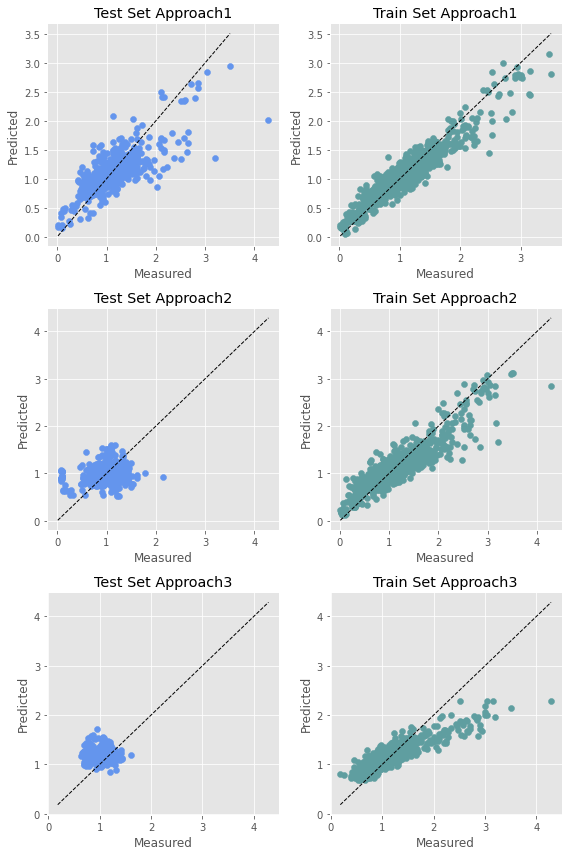

In [116]:
fig, ax = plt.subplots(3,2,figsize=(8,12))

plot_aux(0, y_test_appch1, y_pred_1, y_train_appch1, y_pred_train_1, ax)
plot_aux(1, y_test_appch2, y_pred_2, y_train_appch2, y_pred_train_2, ax)
plot_aux(2, y_test_appch3, y_pred_3, y_train_appch3, y_pred_train_3, ax)

fig.tight_layout()
plt.show()

* As seen Approach 3 using PCA seems to be the one getting the "best" results. However none of them seem to be fitting R0 correctly specially with larger values of R0.
* It is also important to note that the test set has a smaller rangeof values

### Distribution plots

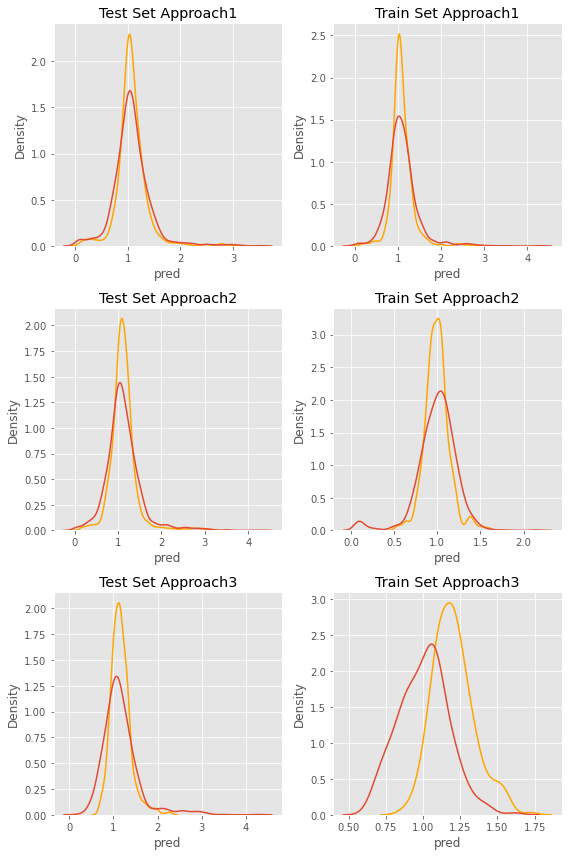

In [117]:
fig, ax = plt.subplots(3,2,figsize=(8,12))

plot_aux_dist(0, y_test_appch1, y_train_appch1, y_pred_1, y_pred_train_1, ax)
plot_aux_dist(1, y_test_appch2, y_train_appch2, y_pred_2, y_pred_train_2, ax)
plot_aux_dist(2, y_test_appch3, y_train_appch3, y_pred_3, y_pred_train_3, ax)

plt.show()

## Gradient Boosting Regressor 

In [118]:
reg1 = GradientBoostingRegressor()
reg2 = GradientBoostingRegressor()
reg3 = GradientBoostingRegressor()

reg1.fit(X_train_appch1_clean, y_train_appch1_clean)
reg2.fit(X_train_appch2_clean, y_train_appch2_clean)
reg3.fit(X_train_appch3_clean, y_train_appch3_clean)


y_pred_1=reg1.predict(X_test_appch1_clean)
y_pred_train_1=reg1.predict(X_train_appch1_clean)
y_pred_2=reg2.predict(X_test_appch2_clean)
y_pred_train_2=reg2.predict(X_train_appch2_clean)
y_pred_3=reg3.predict(X_test_appch3_clean)
y_pred_train_3=reg3.predict(X_train_appch3_clean)

### Evaluation

#### Test Set

In [119]:
df_scores_gbst=get_metrics_data_frame(y_test_appch1_clean,y_pred_1, y_test_appch2_clean, y_pred_2,y_test_appch3_clean, y_pred_3)
df_eval_approach_2.loc['Gradient Boosting'] = df_scores_gbst.loc['Approach 2']
highlight_min(df_scores_gbst)

,mae,mse,rmse,mape
Approach 1,0.144002,0.033782,0.183799,14.164168
Approach 2,0.152828,0.037256,0.193018,15.187412
Approach 3,0.226220,0.076782,0.277096,25.040513


#### Train Set

In [120]:
df_scores_gbst_train=get_metrics_data_frame(y_train_appch1_clean,y_pred_train_1, y_train_appch2_clean, y_pred_train_2,y_train_appch3_clean, y_pred_train_3)
highlight_min(df_scores_gbst_train)

,mae,mse,rmse,mape
Approach 1,0.161465,0.050047,0.223713,19.008456
Approach 2,0.173230,0.058089,0.241017,20.689938
Approach 3,0.211027,0.089318,0.298861,19.858789


## Results View

#### Actual vs Predicted

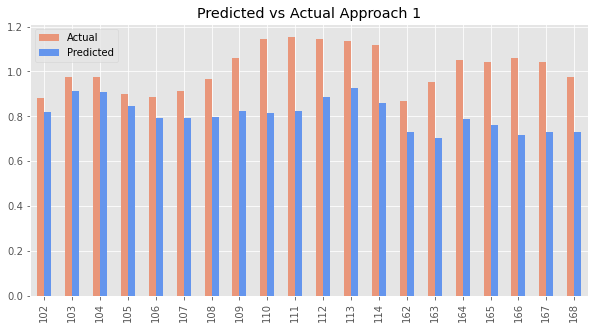

In [121]:
aux_plot_real_vs_pred(0, y_test_appch1_clean, y_pred_1)

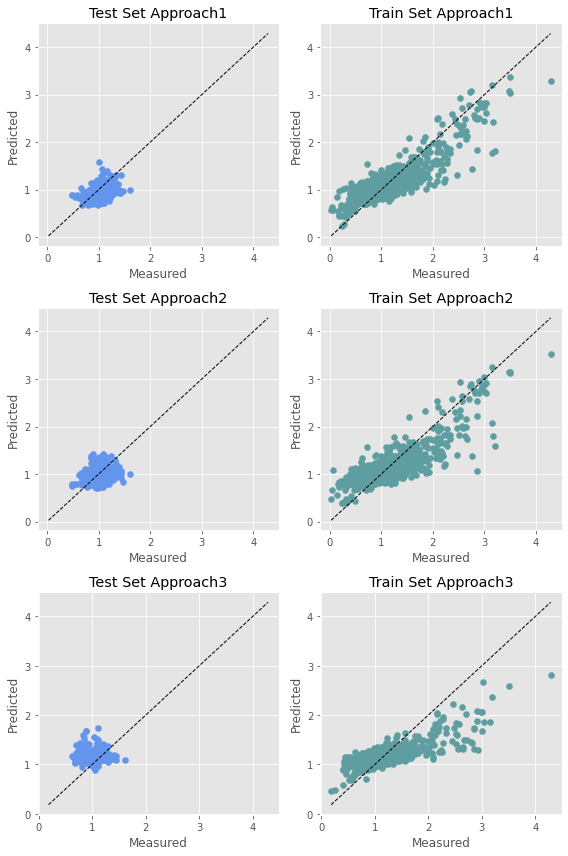

In [122]:
fig, ax = plt.subplots(3,2,figsize=(8,12))

plot_aux(0, y_test_appch1_clean, y_pred_1, y_train_appch1_clean, y_pred_train_1, ax)
plot_aux(1, y_test_appch2_clean, y_pred_2, y_train_appch2_clean, y_pred_train_2, ax)
plot_aux(2, y_test_appch3_clean, y_pred_3, y_train_appch3_clean, y_pred_train_3, ax)

fig.tight_layout()
plt.show()

* As seen Approach 3 using PCA seems to be the one getting the "best" results. However none of them seem to be fitting R0 correctly specially with larger values of R0.
* It is also important to note that the test set has a smaller rangeof values

### Distribution plots

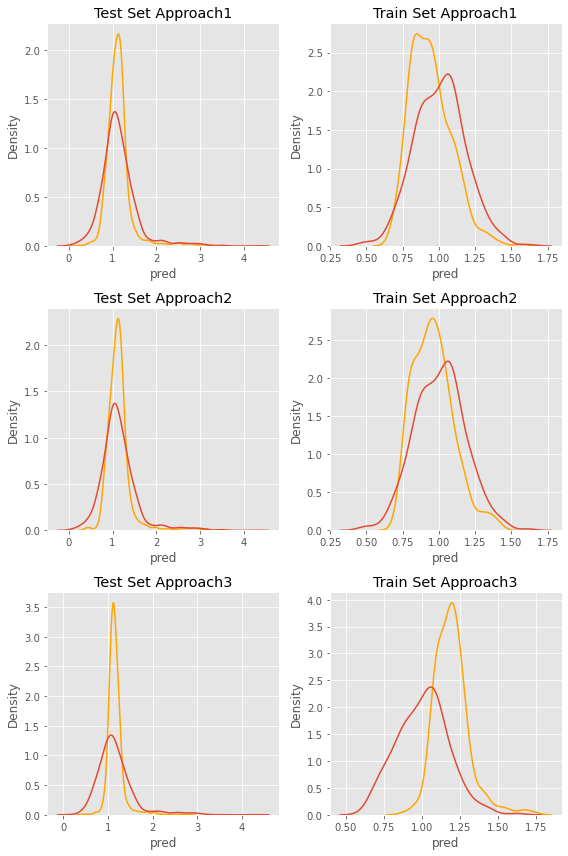

In [123]:
fig, ax = plt.subplots(3,2,figsize=(8,12))

plot_aux_dist(0, y_test_appch1_clean, y_train_appch1_clean, y_pred_1, y_pred_train_1, ax)
plot_aux_dist(1, y_test_appch2_clean, y_train_appch2_clean, y_pred_2, y_pred_train_2, ax)
plot_aux_dist(2, y_test_appch3_clean, y_train_appch3_clean, y_pred_3, y_pred_train_3, ax)

plt.show()

## K Nearest Neighbour Regressor

In [124]:
reg1 = KNeighborsRegressor(n_neighbors=10)
reg2 = KNeighborsRegressor(n_neighbors=10)
reg3 = KNeighborsRegressor(n_neighbors=10)

reg1.fit(X_train_appch1_clean, y_train_appch1_clean)
reg2.fit(X_train_appch2_clean, y_train_appch2_clean)
reg3.fit(X_train_appch3_clean, y_train_appch3_clean)

y_pred_1=reg1.predict(X_test_appch1_clean)
y_pred_train_1=reg1.predict(X_train_appch1_clean)
y_pred_2=reg2.predict(X_test_appch2_clean)
y_pred_train_2=reg2.predict(X_train_appch2_clean)
y_pred_3=reg3.predict(X_test_appch3_clean)
y_pred_train_3=reg3.predict(X_train_appch3_clean)

### Evaluation

#### Test Set

In [125]:
df_scores_knn=get_metrics_data_frame(y_test_appch1_clean,y_pred_1, y_test_appch2_clean, y_pred_2,y_test_appch3_clean, y_pred_3 )
df_eval_approach_2.loc['KNN'] = df_scores_knn.loc['Approach 2']
highlight_min(df_scores_knn)

,mae,mse,rmse,mape
Approach 1,0.158217,0.040194,0.200484,16.793302
Approach 2,0.167897,0.046864,0.216480,17.703165
Approach 3,0.208456,0.067036,0.258912,22.497165


#### Train Set

In [126]:
df_scores_knn_train=get_metrics_data_frame(y_train_appch1_clean,y_pred_train_1, y_train_appch2_clean, y_pred_train_2,y_train_appch3_clean, y_pred_train_3)
highlight_min(df_scores_knn_train)

,mae,mse,rmse,mape
Approach 1,0.183956,0.077549,0.278477,21.267022
Approach 2,0.189367,0.080011,0.282863,22.230297
Approach 3,0.223172,0.115564,0.339947,20.244377


## Results View

#### Actual vs Predicted

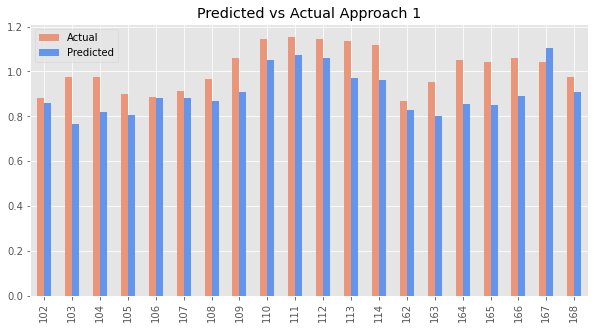

In [127]:
aux_plot_real_vs_pred(0, y_test_appch1_clean, y_pred_1)

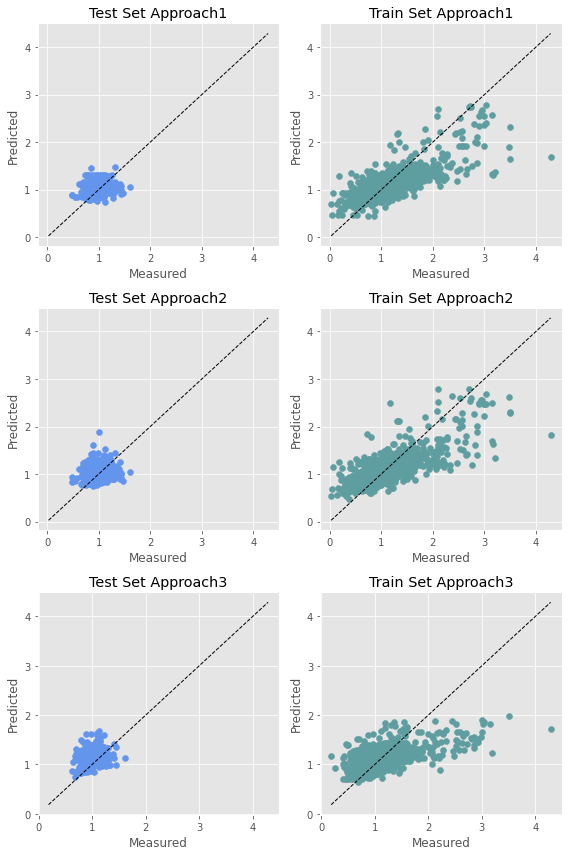

In [128]:
fig, ax = plt.subplots(3,2,figsize=(8,12))

plot_aux(0, y_test_appch1_clean, y_pred_1, y_train_appch1_clean, y_pred_train_1, ax)
plot_aux(1, y_test_appch2_clean, y_pred_2, y_train_appch2_clean, y_pred_train_2, ax)
plot_aux(2, y_test_appch3_clean, y_pred_3, y_train_appch3_clean, y_pred_train_3, ax)

fig.tight_layout()
plt.show()

* As seen Approach 3 using PCA seems to be the one getting the "best" results. However none of them seem to be fitting R0 correctly specially with larger values of R0.
* It is also important to note that the test set has a smaller rangeof values

### Distribution plots

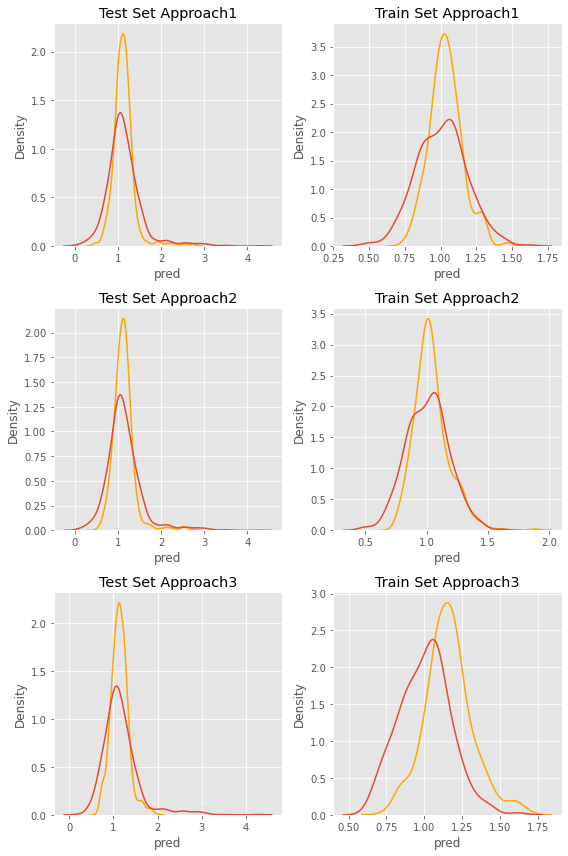

In [129]:
fig, ax = plt.subplots(3,2,figsize=(8,12))

plot_aux_dist(0, y_test_appch1_clean, y_train_appch1_clean, y_pred_1, y_pred_train_1, ax)
plot_aux_dist(1, y_test_appch2_clean, y_train_appch2_clean, y_pred_2, y_pred_train_2, ax)
plot_aux_dist(2, y_test_appch3_clean, y_train_appch3_clean, y_pred_3, y_pred_train_3, ax)

plt.show()

## HistGradientBoostingRegressor

In [133]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
reg1 = HistGradientBoostingRegressor(max_depth=5)
reg2 = HistGradientBoostingRegressor(max_depth=5)
reg3 = HistGradientBoostingRegressor(max_depth=5)

reg1.fit(X_train_appch1_clean, y_train_appch1_clean)
reg2.fit(X_train_appch2_clean, y_train_appch2_clean)
reg3.fit(X_train_appch3_clean, y_train_appch3_clean)

y_pred_1=reg1.predict(X_test_appch1_clean)
y_pred_train_1=reg1.predict(X_train_appch1_clean)
y_pred_2=reg2.predict(X_test_appch2_clean)
y_pred_train_2=reg2.predict(X_train_appch2_clean)
y_pred_3=reg3.predict(X_test_appch3_clean)
y_pred_train_3=reg3.predict(X_train_appch3_clean)

### Evaluation

#### Test Set

In [134]:
df_scores_hist=get_metrics_data_frame(y_test_appch1_clean,y_pred_1, y_test_appch2_clean, y_pred_2,y_test_appch3_clean, y_pred_3 )
df_eval_approach_2.loc['Histogram Gradient Boosting'] = df_scores_hist.loc['Approach 2']
highlight_min(df_scores_hist)

,mae,mse,rmse,mape
Approach 1,0.148880,0.034787,0.186514,14.686294
Approach 2,0.150932,0.036712,0.191605,14.874159
Approach 3,0.236031,0.086151,0.293515,25.992925


#### Train Set

In [135]:
df_scores_hist_train=get_metrics_data_frame(y_train_appch1_clean,y_pred_train_1, y_train_appch2_clean, y_pred_train_2,y_train_appch3_clean, y_pred_train_3)
highlight_min(df_scores_hist_train)

,mae,mse,rmse,mape
Approach 1,0.123403,0.030801,0.175503,14.261911
Approach 2,0.137582,0.037762,0.194326,16.110213
Approach 3,0.163857,0.058958,0.242812,15.193482


## Results View

#### Actual vs Predicted

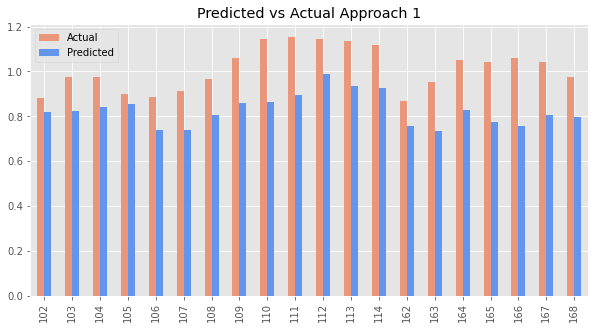

In [136]:
aux_plot_real_vs_pred(0, y_test_appch1_clean, y_pred_1)

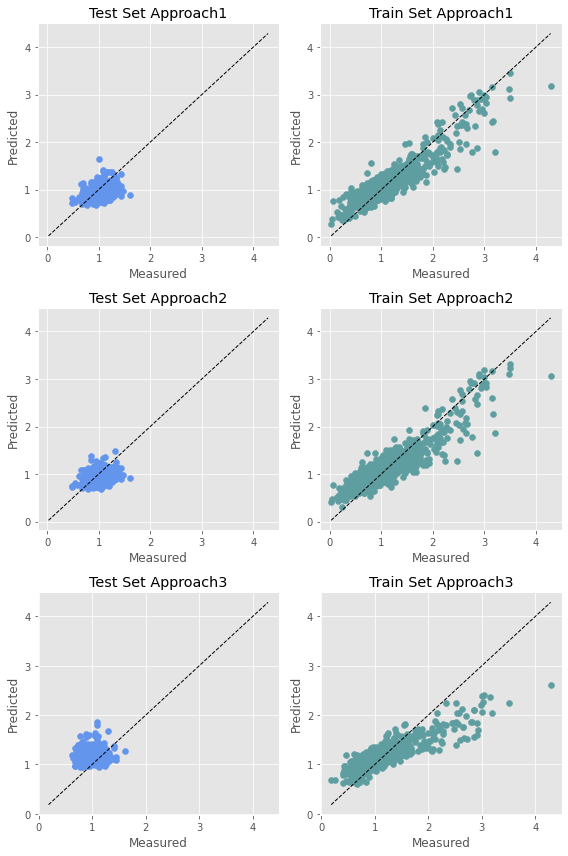

In [137]:
fig, ax = plt.subplots(3,2,figsize=(8,12))

plot_aux(0, y_test_appch1_clean, y_pred_1, y_train_appch1_clean, y_pred_train_1, ax)
plot_aux(1, y_test_appch2_clean, y_pred_2, y_train_appch2_clean, y_pred_train_2, ax)
plot_aux(2, y_test_appch3_clean, y_pred_3, y_train_appch3_clean, y_pred_train_3, ax)

fig.tight_layout()
plt.show()

### Distribution plots

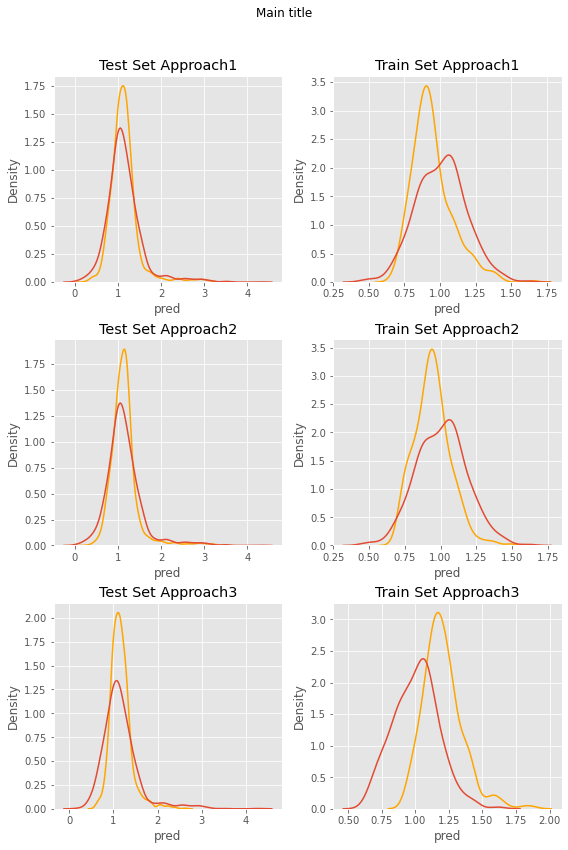

In [138]:
fig, ax = plt.subplots(3,2,figsize=(8,12))

plot_aux_dist(0, y_test_appch1_clean, y_train_appch1_clean, y_pred_1, y_pred_train_1, ax)
plot_aux_dist(1, y_test_appch2_clean, y_train_appch2_clean, y_pred_2, y_pred_train_2, ax)
plot_aux_dist(2, y_test_appch3_clean, y_train_appch3_clean, y_pred_3, y_pred_train_3, ax)

plt.suptitle('Main title')
fig.subplots_adjust(top=0.9)
plt.show()

## NuSVR

In [139]:
from sklearn.svm import NuSVR
reg1 = NuSVR(C=1.0, nu=0.1)
reg2 = NuSVR(C=1.0, nu=0.1)
reg3 = NuSVR(C=1.0, nu=0.1)

reg1.fit(X_train_appch1_clean, y_train_appch1_clean)
reg2.fit(X_train_appch2_clean, y_train_appch2_clean)
reg3.fit(X_train_appch3_clean, y_train_appch3_clean)

y_pred_1=reg1.predict(X_test_appch1_clean)
y_pred_train_1=reg1.predict(X_train_appch1_clean)
y_pred_2=reg2.predict(X_test_appch2_clean)
y_pred_train_2=reg2.predict(X_train_appch2_clean)
y_pred_3=reg3.predict(X_test_appch3_clean)
y_pred_train_3=reg3.predict(X_train_appch3_clean)

### Evaluation

#### Test Set

In [140]:
df_scores_NuSVR=get_metrics_data_frame(y_test_appch1_clean,y_pred_1, y_test_appch2_clean, y_pred_2,y_test_appch3_clean, y_pred_3 )
df_eval_approach_2.loc['NuSVR'] = df_scores_NuSVR.loc['Approach 2']
highlight_min(df_scores_NuSVR)

,mae,mse,rmse,mape
Approach 1,0.192670,0.055395,0.235361,21.001998
Approach 2,0.208879,0.068791,0.262280,22.989074
Approach 3,0.279871,0.108144,0.328853,30.479023


#### Train Set

In [141]:
df_scores_NuSVR_train=get_metrics_data_frame(y_train_appch1_clean,y_pred_train_1, y_train_appch2_clean, y_pred_train_2,y_train_appch3_clean, y_pred_train_3)
highlight_min(df_scores_NuSVR_train)

,mae,mse,rmse,mape
Approach 1,0.203357,0.065286,0.255512,23.126152
Approach 2,0.223696,0.084742,0.291104,26.132614
Approach 3,0.299134,0.150366,0.387771,29.376168


## Results View

#### Actual vs Predicted

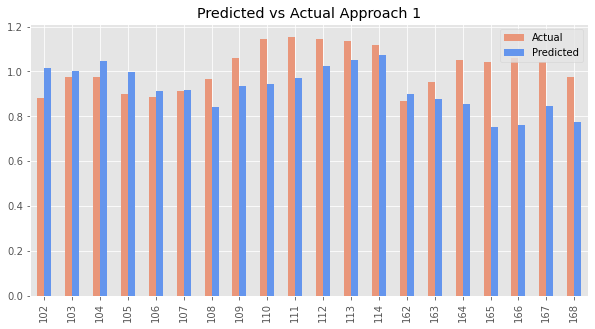

In [142]:
aux_plot_real_vs_pred(0, y_test_appch1_clean, y_pred_1)

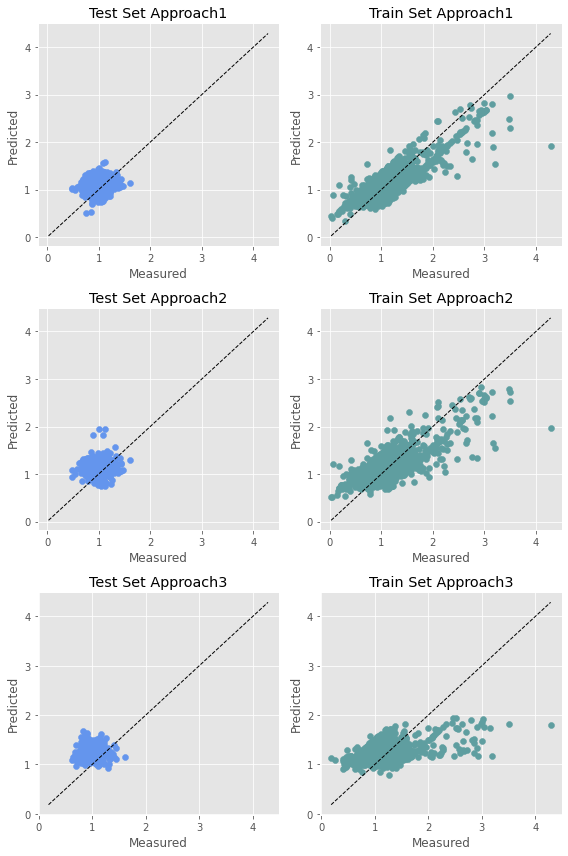

In [143]:
fig, ax = plt.subplots(3,2,figsize=(8,12))

plot_aux(0, y_test_appch1_clean, y_pred_1, y_train_appch1_clean, y_pred_train_1, ax)
plot_aux(1, y_test_appch2_clean, y_pred_2, y_train_appch2_clean, y_pred_train_2, ax)
plot_aux(2, y_test_appch3_clean, y_pred_3, y_train_appch3_clean, y_pred_train_3, ax)

fig.tight_layout()
plt.show()

### Distribution plots

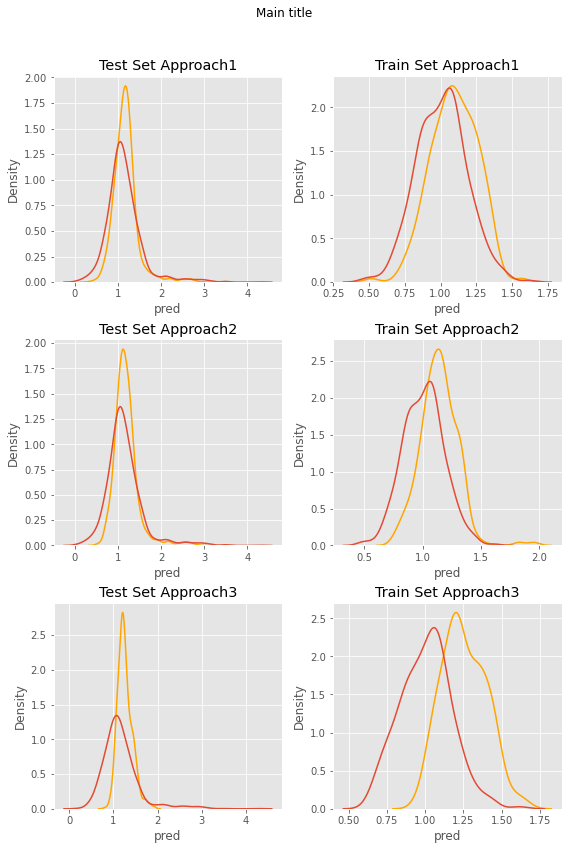

In [144]:
fig, ax = plt.subplots(3,2,figsize=(8,12))

plot_aux_dist(0, y_test_appch1_clean, y_train_appch1_clean, y_pred_1, y_pred_train_1, ax)
plot_aux_dist(1, y_test_appch2_clean, y_train_appch2_clean, y_pred_2, y_pred_train_2, ax)
plot_aux_dist(2, y_test_appch3_clean, y_train_appch3_clean, y_pred_3, y_pred_train_3, ax)

plt.suptitle('Main title')
fig.subplots_adjust(top=0.9)
plt.show()

## Comparing Three Models with Three Approaches

## Boosting Trees

In [145]:
xgb_mae, lgb_mae, gbst_mae, knn_mae, hist_mae, NuSVR_mae = get_values_metric('mae')
xgb_mse, lgb_mse, gbst_mse, knn_mse, hist_mae, NuSVR_mae = get_values_metric('mse')
xgb_rmse, lgb_rmse, gbst_rmse, knn_rmse, hist_mae, NuSVR_mae = get_values_metric('rmse')
xgb_mape, lgb_mape, gbst_mape, knn_mape, hist_mae, NuSVR_mae = get_values_metric('mape')

xgb_mae=xgb_mae.sort_index(ascending=False)
lgb_mae=lgb_mae.sort_index(ascending=False)
gbst_mae=gbst_mae.sort_index(ascending=False)
knn_mae=knn_mae.sort_index(ascending=False)
hist_mae=knn_mae.sort_index(ascending=False)
NuSVR_mae=knn_mae.sort_index(ascending=False)

xgb_mse=xgb_mse.sort_index(ascending=False)
lgb_mse=lgb_mse.sort_index(ascending=False)
gbst_mse=gbst_mse.sort_index(ascending=False)
knn_mse=knn_mse.sort_index(ascending=False)
hist_mse=knn_mse.sort_index(ascending=False)
NuSVR_mse=knn_mse.sort_index(ascending=False)

xgb_rmse=xgb_rmse.sort_index(ascending=False)
lgb_rmse=lgb_rmse.sort_index(ascending=False)
gbst_rmse=gbst_rmse.sort_index(ascending=False)
knn_rmse=knn_rmse.sort_index(ascending=False)
hist_rmse=knn_rmse.sort_index(ascending=False)
NuSVR_rmse=knn_rmse.sort_index(ascending=False)

xgb_mape=xgb_mape.sort_index(ascending=False)
lgb_mape=lgb_mape.sort_index(ascending=False)
gbst_mape=gbst_mape.sort_index(ascending=False)
knn_mape=knn_mape.sort_index(ascending=False)
hist_mape=knn_mape.sort_index(ascending=False)
NuSVR_mape=knn_mape.sort_index(ascending=False)

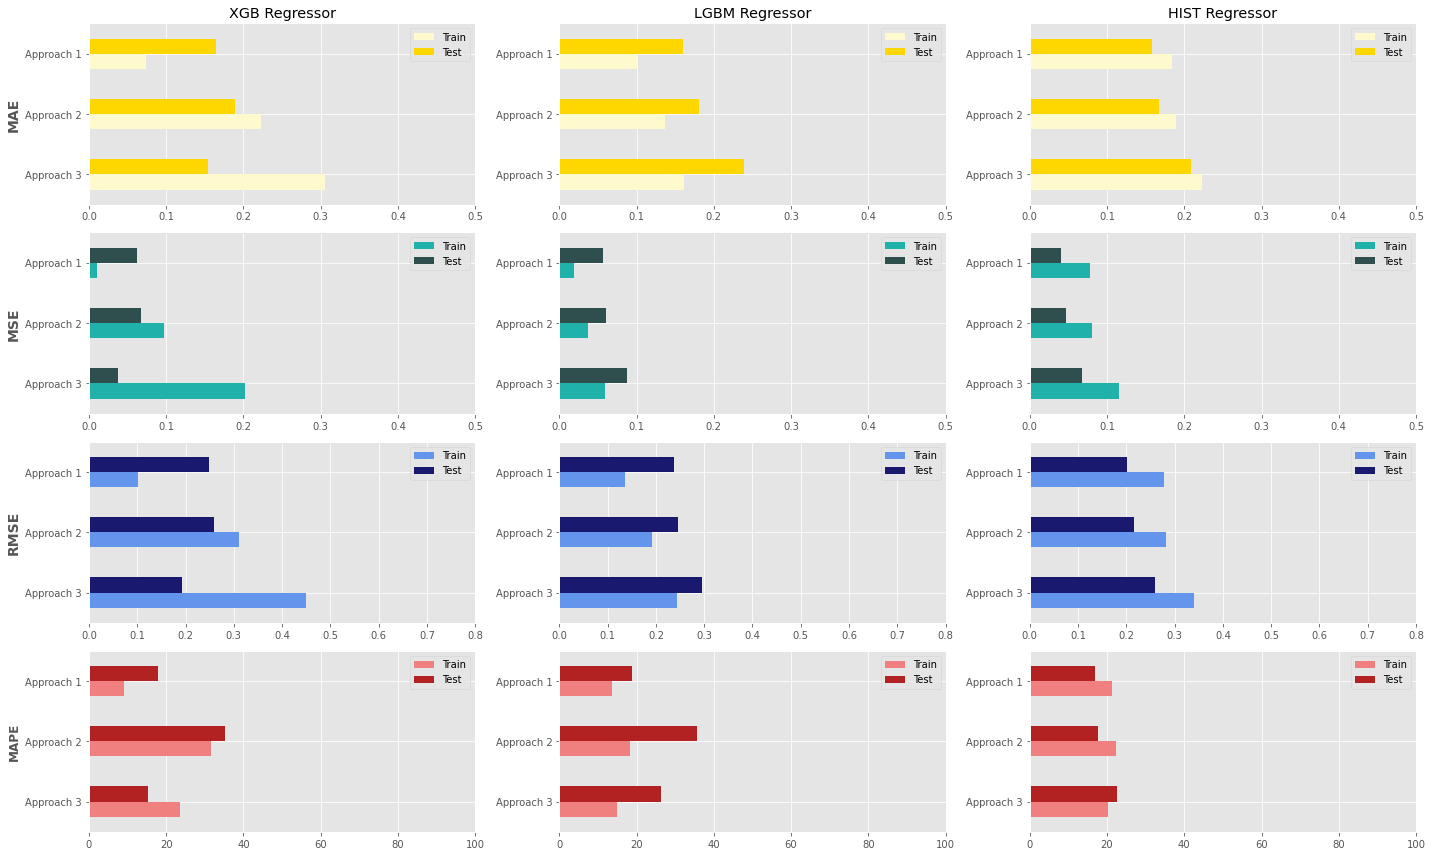

In [146]:
fig, ax = plt.subplots(4,3,figsize=(20,12))

xgb_mae.plot.barh(ax=ax[0][0], color=["lemonchiffon","gold"],title = 'XGB Regressor').set_ylabel('MAE', fontsize=14.0, fontweight='bold')
lgb_mae.plot.barh(ax=ax[0][1], color=["lemonchiffon","gold"],title = 'LGBM Regressor')
hist_mae.plot.barh(ax=ax[0][2], color=["lemonchiffon","gold"],title = 'HIST Regressor')
xgb_mse.plot.barh(ax=ax[1][0], color=["lightseagreen","darkslategray"]).set_ylabel('MSE', fontsize=14.0, fontweight='bold')
lgb_mse.plot.barh(ax=ax[1][1], color=["lightseagreen","darkslategray"])
hist_mse.plot.barh(ax=ax[1][2], color=["lightseagreen","darkslategray"])
xgb_rmse.plot.barh(ax=ax[2][0], color=["cornflowerblue","midnightblue"]).set_ylabel('RMSE', fontsize=14.0, fontweight='bold')
lgb_rmse.plot.barh(ax=ax[2][1], color=["cornflowerblue","midnightblue"])
hist_rmse.plot.barh(ax=ax[2][2], color=["cornflowerblue","midnightblue"])
xgb_mape.plot.barh(ax=ax[3][0], color=["lightcoral","firebrick"]).set_ylabel('MAPE',fontsize=12.0, fontweight='bold')
lgb_mape.plot.barh(ax=ax[3][1], color=["lightcoral","firebrick"])
hist_mape.plot.barh(ax=ax[3][2], color=["lightcoral","firebrick"])

ax[0][0].set_xlim([0, 0.5])
ax[0][1].set_xlim([0, 0.5])
ax[0][2].set_xlim([0, 0.5])

ax[1][0].set_xlim([0, 0.5])
ax[1][1].set_xlim([0, 0.5])
ax[1][2].set_xlim([0, 0.5])

ax[2][0].set_xlim([0, 0.8])
ax[2][1].set_xlim([0, 0.8])
ax[2][2].set_xlim([0, 0.8])

ax[3][0].set_xlim([0, 100])
ax[3][1].set_xlim([0, 100])
ax[3][2].set_xlim([0, 100])

fig.tight_layout()

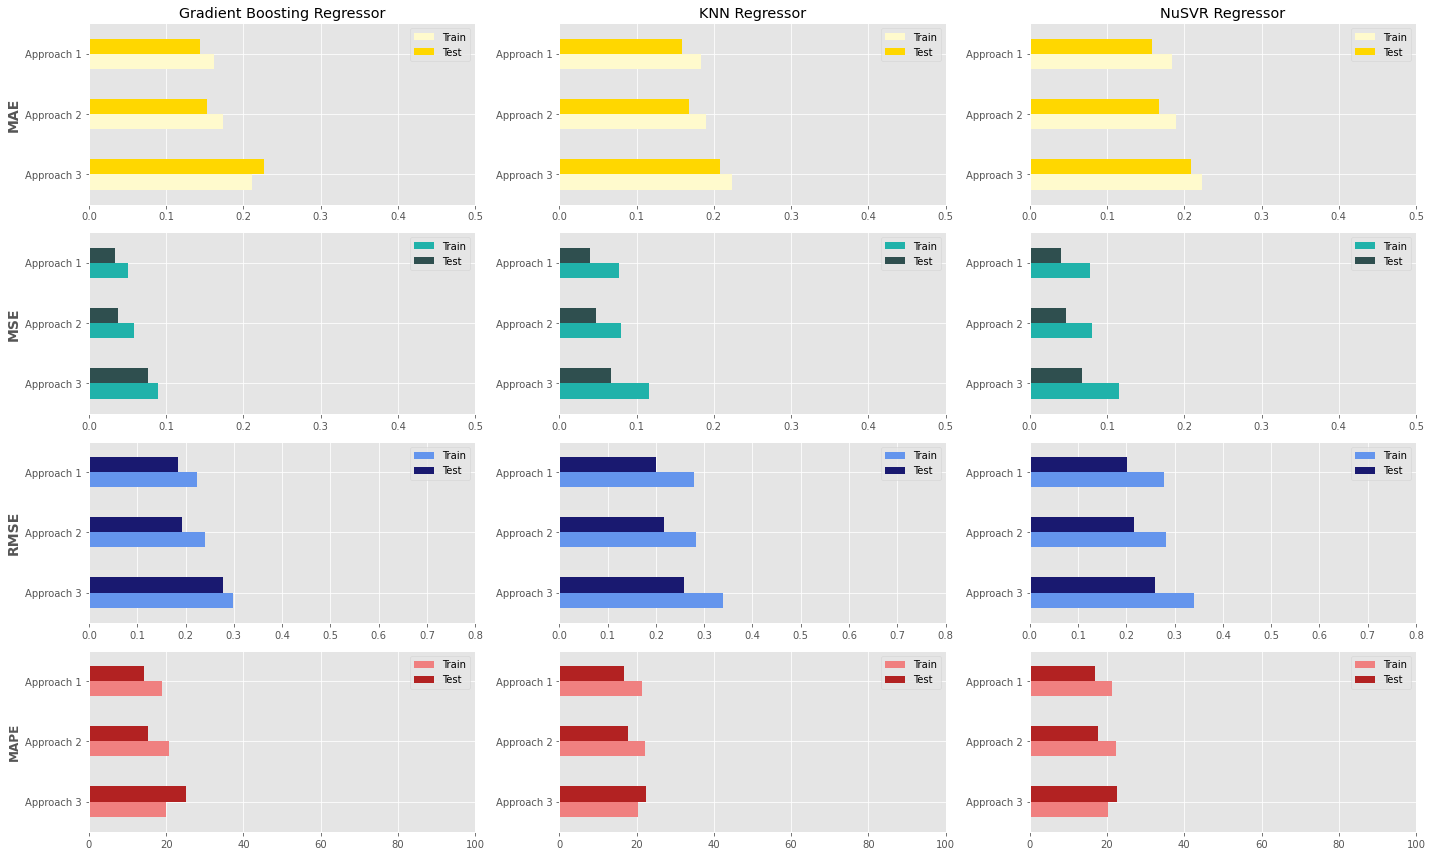

In [147]:
fig, ax = plt.subplots(4,3,figsize=(20,12))

gbst_mae.plot.barh(ax=ax[0][0], color=["lemonchiffon","gold"],title = 'Gradient Boosting Regressor').set_ylabel('MAE', fontsize=14.0, fontweight='bold')
knn_mae.plot.barh(ax=ax[0][1], color=["lemonchiffon","gold"],title = 'KNN Regressor')
NuSVR_mae.plot.barh(ax=ax[0][2], color=["lemonchiffon","gold"],title = 'NuSVR Regressor')
gbst_mse.plot.barh(ax=ax[1][0], color=["lightseagreen","darkslategray"]).set_ylabel('MSE', fontsize=14.0, fontweight='bold')
knn_mse.plot.barh(ax=ax[1][1], color=["lightseagreen","darkslategray"])
NuSVR_mse.plot.barh(ax=ax[1][2], color=["lightseagreen","darkslategray"])
gbst_rmse.plot.barh(ax=ax[2][0], color=["cornflowerblue","midnightblue"]).set_ylabel('RMSE', fontsize=14.0, fontweight='bold')
knn_rmse.plot.barh(ax=ax[2][1], color=["cornflowerblue","midnightblue"])
NuSVR_rmse.plot.barh(ax=ax[2][2], color=["cornflowerblue","midnightblue"])
gbst_mape.plot.barh(ax=ax[3][0], color=["lightcoral","firebrick"]).set_ylabel('MAPE',fontsize=12.0, fontweight='bold')
knn_mape.plot.barh(ax=ax[3][1], color=["lightcoral","firebrick"])
NuSVR_mape.plot.barh(ax=ax[3][2], color=["lightcoral","firebrick"])

ax[0][0].set_xlim([0, 0.5])
ax[0][1].set_xlim([0, 0.5])
ax[0][2].set_xlim([0, 0.5])

ax[1][0].set_xlim([0, 0.5])
ax[1][1].set_xlim([0, 0.5])
ax[1][2].set_xlim([0, 0.5])

ax[2][0].set_xlim([0, 0.8])
ax[2][1].set_xlim([0, 0.8])
ax[2][2].set_xlim([0, 0.8])

ax[3][0].set_xlim([0, 100])
ax[3][1].set_xlim([0, 100])
ax[3][2].set_xlim([0, 100])

fig.tight_layout()

## Evaluating Results for Approach 2

Text(0.5, 1.0, 'MAPE')

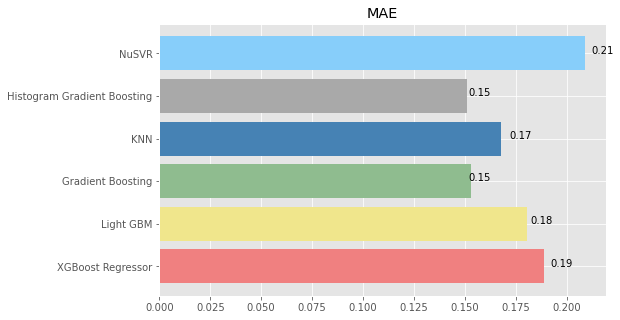

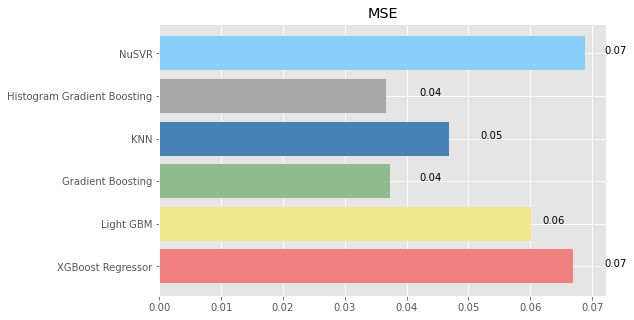

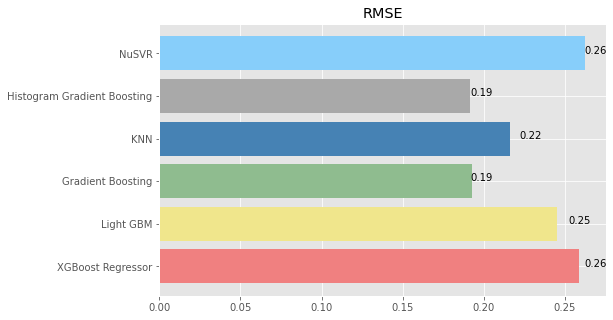

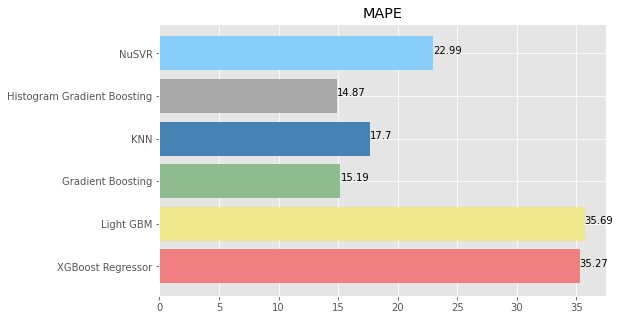

In [148]:
colors = ['lightcoral', 'khaki', 'darkseagreen', 'steelblue', 'darkgray', 'lightskyblue']
y=np.round(df_eval_approach_2['mae'], decimals=2)

fig, ax = plt.subplots(figsize=(8, 5)) 
ind=np.arange(len(df_eval_approach_2))
ax.barh(ind, df_eval_approach_2['mae'], color=colors)
plt.yticks(ind,df_eval_approach_2.index.tolist())

for i, v in enumerate(y):
    ax.text(v+0.002, i, str(v), color='black')
ax.set_title('MAE')

y=np.round(df_eval_approach_2['mse'], decimals=2)

fig, ax = plt.subplots(figsize=(8, 5)) 
ind=np.arange(len(df_eval_approach_2))
ax.barh(ind, df_eval_approach_2['mse'], color=colors)
plt.yticks(ind,df_eval_approach_2.index.tolist())

for i, v in enumerate(y):
    ax.text(v+0.002, i, str(v), color='black')
ax.set_title('MSE')

y=np.round(df_eval_approach_2['rmse'], decimals=2)

fig, ax = plt.subplots(figsize=(8, 5)) 
ind=np.arange(len(df_eval_approach_2))
ax.barh(ind, df_eval_approach_2['rmse'], color=colors)
plt.yticks(ind,df_eval_approach_2.index.tolist())

for i, v in enumerate(y):
    ax.text(v+0.002, i, str(v), color='black')
ax.set_title('RMSE')

y=np.round(df_eval_approach_2['mape'], decimals=2)

fig, ax = plt.subplots(figsize=(8, 5)) 
ind=np.arange(len(df_eval_approach_2))
ax.barh(ind, df_eval_approach_2['mape'], color=colors)
plt.yticks(ind,df_eval_approach_2.index.tolist())

for i, v in enumerate(y):
    ax.text(v+0.002, i, str(v), color='black')
ax.set_title('MAPE')

## Cross Validation

aux=df.copy().reset_index()
aux=aux.sort_values('Date')
X=aux[aux.columns[3:-1]]
y=aux[aux.columns[-1]]

k = 10
kf = KFold(n_splits=k, random_state=None)
 
acc_score = []
 
for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
    
    grid.fit(X_train, y_train)
    pred_values = grid.best_estimator_.predict(X_test)
     
    acc = np.mean(np.abs((y_test - pred_values) / y_test)) * 100
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k

avg_acc_score

acc_score